# NAIVE BAYES SPAM FILTER #

## CMSC 197, Problem Set 2 ##

Submitted to: Ms. Ara Abigail E. Ambita <br>
Submitted by: Dosado, Michael Vincent  201904469  BS CS IV   

In [1]:
# Libraries Used 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import re
import email 
import codecs
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score

**Preprocessing**

In [2]:
# initialization of the primary dataframe 
# The folder in which the email is located, the email's filename, the email message, and 
# its classification as spam or ham are all mentioned in the columns. 
# 0 for ham and 1 for spam.

df = pd.DataFrame(columns = ['folder', 'file', 'email_message', 'classification'])
df

,folder,file,email_message,classification


In [3]:
# Initialize data frame for the Labels

labels_path = "trec06/labels"
df_labels = pd.read_csv("trec06/labels", sep = " ", header = None)

# Columns
df_labels.columns = ["classification", "filepath"]

# ham indicated by  0 and spam indicated by 1
df_labels["classification"] = df_labels["classification"].apply(lambda kv: 0 if kv == "ham" else 1)
#Get rid of "../data/" from filepath
df_labels["filepath"] = df_labels["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_labels

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [4]:
#LIST THE FOLDERS IN THE DATA DIRECTORY

folder_path = "trec06/data"
#Create variable called folders
folders = os.listdir(folder_path)
folders

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [5]:
# Removal of Punctuation marks,Numbers,Escape characters,
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
num = "0123456789"
esc = re.compile(r'\\[a-z][a-z]?[0-9]+')
tags = re.compile('<.*?>') 
stop_words = []
# List of data from the email that will be removed
# reading the stop_words text file taking the stop words to be added into the list
with open('stop_words.txt', 'r') as file:
    stop_word = file.read().splitlines()
    stop_words = [word for word in stop_word]

In [6]:
#Function to Delete any unnecessary information found in the email.
def drop_info(msg):
    #conversion of text to lowercase to even the font format for uniformity with stop words
    msg = msg.lower()
    msg = re.sub(tags, '', msg) #Removal of HTML tags
    msg = msg.translate(str.maketrans('', '', punc))#Removal of punctuation marks
    msg = msg.translate(str.maketrans('', '', num))#Removal of numbers
    msg = re.sub(esc, '', repr(msg))#Removal of  escape characters
    msg = codecs.decode(msg, 'unicode_escape') #Convert raw string to have unicode escape characters
    words = msg.split()   #Splits msg (string) into a list of words
    words = [word for word in words if word not in stop_words]  #Removal of stop words or meaningless words
    
    
    #Joining the words
    msg = " ".join(words)
    msg = msg.strip("'")
    return msg

#Get message from parsed email function
def get_msg(parsed):
    msg = ""
    #If it is a multipart email,
    if parsed.is_multipart():
        #Iterate over parts of the email
        for part in parsed.walk():
            #If the content type of the part is text/plain,
            if part.get_content_type() == 'text/plain':
                #Get the message
                msg = part.get_payload()
                break
    #Otherwise, just get the message
    else:
        msg = parsed.get_payload()
    return msg

*_Preprocessing of the Entire Trec06 Dataset_*

Each email will be preprocessed in a standard character set which is ISO-8859-1 and unnecessary information will be removed.

In [7]:
# Preprocessing of the Entire Trec06 Dataset

# Every email will go through preprocessing in the ISO-8859-1 character set to remove any extraneous information.


# Each email is Read and is placed them in a dataframe
for folder in folders:
    #Retrieve the files from the folder.
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
        with open(f"{folder_path}/{folder}/{file}", "r", encoding = "ISO-8859-1") as e_mail:
            read_email_file = e_mail.read()
            parsed = email.message_from_string(read_email_file)
            msg = get_msg(parsed)
            msg = drop_info(msg)
            #Obtain the email's classification based on the Labels dataframe.
            labels_classification = df_labels[df_labels['filepath'] == f"{folder}/{file}"]['classification'].values[0]
            #concatenate the data to the primary dataframe.
            df = pd.concat([df, pd.DataFrame([[folder, file, msg, labels_classification]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
df

,folder,file,email_message,classification
0,000,000,the mailing list queried weeks ago running set...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgar...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,try chauncey conferred luscious continued tons...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1
37818,126,018,the oil sector going crazy weekly gift kkpt th...,1
37819,126,019,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,020,u prosperous future increased money earning po...,1


In [8]:
# Save the main dataframe as preprocessed emails.csv and create a subdirectory containing preprocessed files.


if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')
df.to_csv("preprocessed_files/preprocessed_emails.csv", index = False)
#In order to prevent memory overflow, reset the main dataframe.
df.drop(df.index, inplace = True)
df = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df


,folder,file,email_message,classification


In [9]:
#The preprocessed data import


df2 = pd.read_csv("./preprocessed_files/preprocessed_emails.csv")

#SEPARATE THE DATASET INTO HAM TRAINING, SPAM TRAINING, AND THE TESTING SET.

#Train Set ----   Folders 0-70
training_df = df2[df2['folder'] < 71]
# Test Set ----   Folders 71-126
testing_df = df2[df2['folder'] >= 71]

training_ham_df = training_df[training_df['classification'] == 0]
training_spam_df = training_df[training_df['classification'] == 1]

df2


,folder,file,email_message,classification
0,0,0,the mailing list queried weeks ago running set...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgar...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,try chauncey conferred luscious continued tons...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,u prosperous future increased money earning po...,1


In [10]:
training_ham_df

,folder,file,email_message,classification
0,0,0,the mailing list queried weeks ago running set...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,its quiet quiet well straw poll plan running,0
6,0,6,its working departed totally bell labs recomme...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
21270,70,270,here equation generate prime numbers equation ...,0
21271,70,271,here equation generate prime numbers equation ...,0
21288,70,288,dear dmdx users guidance generating dmdx item...,0
21293,70,293,hi built handyboard works great testmotor pass...,0


In [11]:
training_spam_df

,folder,file,email_message,classification
1,0,1,luxury watches buy rolex rolex cartier bvlgar...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,try chauncey conferred luscious continued tons...,1
7,0,7,from nbc today body diet beaches magazines hol...,1
8,0,8,the oil sector going crazy weekly gift kkpt th...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,bbtijclnabb bbinpqnejgmbb httpgethighbizez bbl...,1
21296,70,296,special offer adobe video collection adobe pr...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [12]:
testing_df

,folder,file,email_message,classification
21300,71,0,where hesitantly derive perverse satisfaction ...,1
21301,71,1,things perform experiment display will remain...,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
21304,71,4,special offer adobe video collection adobe pr...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,u prosperous future increased money earning po...,1


In [13]:
# The training set will be used to generate a list of distinct terms, together with the words' total number of occurrences.
# Set of ham with spam. We'll just extract the top 10,000 terms from the dictionary in order to reduce its cardinality.


# Dictionary where the word is the key and its count is the value
thisdict = {}

for index, row in training_df.iterrows():
    for word in str(row['email_message']).split():
        if word in thisdict:
            thisdict[word] += 1
        else:
            thisdict[word] = 1

#Dictionary values should be sorted in decreasing order by sorting
sorted_d = sorted(thisdict.items(), key = lambda kv: kv[1], reverse = True)

#Taking 10,000 of the most frequent terms
most_common_words = dict(sorted_d[:10000])
most_common_words




{'bbbb': 16633,
 'will': 11325,
 'board': 5169,
 'company': 4523,
 'price': 4497,
 'gold': 4252,
 'email': 4086,
 'list': 3950,
 'adobe': 3913,
 'time': 3830,
 'nil': 3830,
 'help': 3801,
 'send': 3655,
 'message': 3613,
 'dont': 3573,
 'subject': 3568,
 'crustl': 3295,
 'received': 3093,
 'program': 3081,
 'Ã¨': 2908,
 'windows': 2867,
 'work': 2782,
 'professional': 2782,
 'Ã': 2760,
 'wrote': 2688,
 'well': 2650,
 'ms': 2599,
 'good': 2498,
 'china': 2484,
 'number': 2463,
 'university': 2436,
 'problem': 2361,
 'file': 2247,
 'office': 2247,
 'stock': 2243,
 'handyboard': 2231,
 'hi': 2230,
 'hb': 2190,
 'bit': 2188,
 'de': 2170,
 'Ã\xadÃ': 2161,
 'corp': 2142,
 'info': 2135,
 'microsoft': 2128,
 'current': 2083,
 'add': 2062,
 'studies': 2004,
 'pro': 2000,
 'contenttype': 1973,
 'news': 1971,
 'code': 1952,
 'development': 1936,
 'find': 1927,
 'womens': 1888,
 'Ã¢': 1878,
 'great': 1855,
 'people': 1846,
 'today': 1804,
 'read': 1797,
 'best': 1797,
 'system': 1775,
 'save': 175

In [14]:
#  The feature matrix creation

#  THE SPAM TRAINING SET'S FEATURE MATRIX
#  Dimensionality: 10,000

featurematrix_spam = np.zeros((len(training_spam_df), 10000))
list_most_common_words = list(most_common_words.keys())

for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            featurematrix_spam[index][list_most_common_words.index(word)] = 1

featurematrix_spam

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
# HAM TRAINING SET FEATURE MATRIX
featurematrix_ham = np.zeros((len(training_ham_df), 10000))

for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            featurematrix_ham[index][list_most_common_words.index(word)] = 1

featurematrix_ham

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
#  Computing the Priors

#  Using the following formula, get the prior probabilities for ham and spam
#  P(𝘤 = 𝘩𝘢𝘮) = Nₕₐₘ/Ndₒc <br>
#  P(𝘤 = 𝘴𝘱𝘢𝘮) = Nₛₚₐₘ/Ndₒc


nham = len(training_ham_df)    # Number of ham emails in the training set
nspam = len(training_spam_df)  # Number of spam emails in the training set

ndoc = len(training_df)        #Total number of emails

#Formulas to be used
p_ham = nham/ndoc
p_spam = nspam/ndoc

print("P(c = ham) = ", p_ham)
print("P(c = spam) = ",p_spam)

P(c = ham) =  0.3531924882629108
P(c = spam) =  0.6468075117370892


In [17]:
#   calculating each word's likelihood

#   The function that follows uses laplace smoothing to determine the likelihoods of each word.



def laplace_smoothing(featurematrix_spam, featurematrix_ham):
    prob_spam = np.zeros(len(most_common_words))   # We initialize the likelihood of each phrase given spam and ham.
    prob_ham = np.zeros(len(most_common_words))
    wordcount_spam = np.sum(featurematrix_spam, axis = 0) # Word count of spam and ham
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    totalwords_spam = np.sum(wordcount_spam) #Total number of words in spam and ham
    totalwords_ham = np.sum(wordcount_ham)
    
    #Set the laplace smoothing parameter and the class count to their initial values.
    param = 1
    num_of_classes = 2

    #Formula for calculating each word's likelihood using Laplace smoothing
    for i in range(len(most_common_words)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

likelihood_spam, likelihood_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham)

print("The likelihood of each word given spam with laplace smoothing is ", likelihood_spam)
print("The likelihood of each word given ham with laplace smoothing is ", likelihood_ham)

The likelihood of each word given spam with laplace smoothing is  [2.06551392e-03 4.89809168e-03 9.93847926e-04 ... 4.22440953e-05
 2.22337344e-06 2.22337344e-06]
The likelihood of each word given ham with laplace smoothing is  [8.30925956e-06 6.38428110e-03 5.58659218e-03 ... 1.38487659e-05
 3.60067914e-05 4.98555574e-05]


In [18]:
#   Classifying the emails

# Function that classifies the emails
def classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    log_prob_ham = 0      # setting the ham and spam log probability to zero by initialization
    log_prob_spam = 0
    words = str(email).split()   #Splitting the email into words
    # Log probabilities computation
    for word in words:
        if word in most_common_words:
            log_prob_ham += np.log(likelihood_ham[list_most_common_words.index(word)])
            log_prob_spam += np.log(likelihood_spam[list_most_common_words.index(word)])
    # adding the ham and spam log probability
    log_prob_ham += np.log(p_ham)
    log_prob_spam += np.log(p_spam)
    # Return the one with the highest probability
    if log_prob_ham > log_prob_spam:
        return 0
    else:
        return 1

# Sorting of train emails
training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4796\4285402314.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))


In [19]:
# Determine the appropriate amount of predictions.
count = 0
for index, row in training_df.iterrows():
    if float(row['classification']) == float(row['pred']):
        count += 1
print("Out of",len(training_df)  , " emails, the number of emails that are classified correctly is ",  count, " The percentage of correctly classified emails is ",(count/len(training_df)*100))

Out of 21300  emails, the number of emails that are classified correctly is  20423  The percentage of correctly classified emails is  95.88262910798122


In [20]:
# Testing the Classifier

# Sorting of test emails
testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))

testing_df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4796\2193499923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))


,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


In [21]:
#Calculate the correct number of predictions
count = 0
for index, row in testing_df.iterrows():
    if float(row['classification']) == float(row['pred']):
        count += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(testing_df), count, count/len(testing_df)*100))      

Out of 16522 emails, the number of emails that are classified correctly is 15371. The percentage of correctly classified emails is 93.03353104950975%.


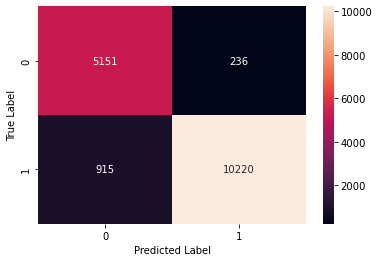

False Positive Rate (FP) -  236
False Negative Rate (FN) -  915
True Positive Rate (TP) -  10220
True Negative Rate (TN)  -  5151


In [22]:
# Performance Evaluation

# confusion matrix:

actual = np.array(testing_df['classification'])
predicted = np.array(testing_df['pred'])

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels = [0, 1])

sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - ", (confusion_matrix[0][1])) 
print("False Negative Rate (FN) - ", (confusion_matrix[1][0])) 
print("True Positive Rate (TP) - ", (confusion_matrix[1][1])) 
print("True Negative Rate (TN)  - ", (confusion_matrix[0][0])) 

In [23]:
# EVALUATION MEASURES FOR SPAM FILTERS (Accuracy, Recall, Precision)

from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted)
precision = precision_score(actual, predicted)

print("Accuracy - ", (accuracy))
print("Recall - ", (recall))
print("Precision  - ", (precision))

Accuracy -  0.9303353104950974
Recall -  0.9178266726537944
Precision  -  0.9774292272379494


In [24]:
###                Results and Discussion                  ###

# Guide questions:

#  1. What is the effect of removing stop words in terms of precision, recall, and accuracy? 
#     Show a plot or a table of these results.



In [62]:
#  To do this, we will be running through the same process from the beginning, but this time the Stop words are removed


df3 = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
path_to_lab = "trec06/labels"
df_lab = pd.read_csv("trec06/labels", sep = " ", header = None)
df_lab.columns = ["classification", "filepath"]
df_lab["classification"] = df_lab["classification"].apply(lambda kv: 0 if kv == "ham" else 1)
df_lab["filepath"] = df_lab["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_lab

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [26]:
path_to_lab = "trec06/labels"
df_lab = pd.read_csv("trec06/labels", sep = " ", header = None)
df_lab.columns = ["classification", "filepath"]
df_lab["classification"] = df_lab["classification"].apply(lambda kv: 0 if kv == "ham" else 1)
df_lab["filepath"] = df_lab["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_lab

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [27]:
folder_path = "trec06/data"
folders = os.listdir(folder_path)
folders 

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [28]:
punct = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
numb = "0123456789"
esca = re.compile(r'\\[a-z][a-z]?[0-9]+')
html = re.compile('<.*?>') 
stopwords = []
with open('stop_words.txt', 'r') as file:
    stopword = file.read().splitlines()
    stopwords = [word for word in stopword]

In [29]:
def remove_info(message):
    wor = message.split()
    message = " ".join(wor)
    message = message.lower()
    message = re.sub(html, '', message)
    message = message.translate(str.maketrans('', '', punct))
    message = message.translate(str.maketrans('', '', numb))
    message = re.sub(esca, '', repr(message))
    message = codecs.decode(message, 'unicode_escape')
    message = message.strip("'")
    return message

def get_message(parsed_email):
    message = ""
    if parsed_email.is_multipart():
        for par in parsed_email.walk():
            if par.get_content_type() == 'text/plain':
                message = par.get_payload()
                break
    else:
        message = parsed_email.get_payload()
    return message

In [30]:
for folder in folders:
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
            read_file = e_mail.read()
            parsed_email = email.message_from_string(read_file)
            message = get_message(parsed_email)
            message = remove_info(message)
            labels_class = df_lab[df_lab["filepath"] == f"{folder}/{file}"]["classification"].values[0]
            df3 = pd.concat([df3, pd.DataFrame([[folder, file, message, labels_class]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
df3

,folder,file,email_message,classification
0,000,000,the mailing list i queried about a few weeks a...,0
1,000,001,luxury watches buy your own rolex for only r...,1
2,000,002,academic qualifications available from prestig...,1
3,000,003,greetings all this is to verify your subscript...,0
4,000,004,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures inc infx...,1
37818,126,018,the oil sector is going crazy this is our week...,1
37819,126,019,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,020,u n i v e r s i t y d i p l o m a s do you wan...,1


In [31]:
if not os.path.exists("preprocessed_files"):
    os.makedirs("preprocessed_files")

df3.to_csv("preprocessed_files/preprocessed_emails_2.csv", index = False)

df3.drop(df3.index, inplace = True)
df3 = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df3

,folder,file,email_message,classification


In [32]:
df4 = pd.read_csv("preprocessed_files/preprocessed_emails_2.csv")

train_df = df4[df4['folder'] < 71]
test_df = df4[df4['folder'] >= 71]

train_ham_df = train_df[train_df['classification'] == 0]
train_spam_df = train_df[train_df['classification'] == 1]

In [68]:
df4

,folder,file,email_message,classification
0,0,0,the mailing list i queried about a few weeks a...,0
1,0,1,luxury watches buy your own rolex for only r...,1
2,0,2,academic qualifications available from prestig...,1
3,0,3,greetings all this is to verify your subscript...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1
37818,126,18,the oil sector is going crazy this is our week...,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1


In [65]:
train_ham_df

,folder,file,email_message,classification
0,0,0,the mailing list i queried about a few weeks a...,0
3,0,3,greetings all this is to verify your subscript...,0
5,0,5,its quiet too quiet well how about a straw pol...,0
6,0,6,its working here i have departed almost totall...,0
10,0,10,greetings all this is a mass acknowledgement t...,0
...,...,...,...,...
21270,70,270,here is an equation that generate all prime nu...,0
21271,70,271,here is an equation that generate all prime nu...,0
21288,70,288,dear dmdx users i would like guidance in gener...,0
21293,70,293,hi i built up a handyboard and most of it work...,0


In [66]:
train_spam_df

,folder,file,email_message,classification
1,0,1,luxury watches buy your own rolex for only r...,1
2,0,2,academic qualifications available from prestig...,1
4,0,4,try chauncey may conferred the luscious not co...,1
7,0,7,from nbc today show its the look everyone want...,1
8,0,8,the oil sector is going crazy this is our week...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,bbtijclnabb bbinpqnejgmbb httpgethighbizez bbl...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,lovechocolatbbgissbb bbbbbbbbbbbbbbbblo...,1


In [67]:
test_df

,folder,file,email_message,classification,predi
21300,71,0,where we can hesitantly derive perverse satisf...,1,1
21301,71,1,there are several things you can use to perfor...,0,0
21302,71,2,best offer of the month viggra ci ialis va...,1,1
21303,71,3,de i ar home o h wne n r your cr v ed b it d...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1,1
37818,126,18,the oil sector is going crazy this is our week...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1,1


In [69]:
thedict = {}

for index, row in train_df.iterrows():
    for wor in str(row['email_message']).split():
        if wor in thedict:
            thedict[wor] += 1
        else:
            thedict[wor] = 1

sorted_dict = sorted(thedict.items(), key=lambda kv: kv[1], reverse = True)

mostcommonwords = dict(sorted_dict[:10000])
list_mostcommonwords = list(mostcommonwords.keys())
mostcommonwords

{'the': 129727,
 'to': 80392,
 'a': 67100,
 'and': 62016,
 'of': 56432,
 'i': 42290,
 'in': 39071,
 'is': 35240,
 'for': 30112,
 'you': 29505,
 'that': 24148,
 'it': 22247,
 'on': 21873,
 'this': 21225,
 'with': 19880,
 'be': 18038,
 'from': 17223,
 'have': 15458,
 'are': 14848,
 'as': 14043,
 'your': 13673,
 'at': 13079,
 'or': 12743,
 'by': 12264,
 'not': 12138,
 'will': 11305,
 'we': 11160,
 'if': 10534,
 'but': 10218,
 'can': 10111,
 'an': 8874,
 'all': 8430,
 'has': 7877,
 'our': 7661,
 'my': 7431,
 'was': 7149,
 'one': 7113,
 'bbbb': 6719,
 'any': 6637,
 'its': 6631,
 'more': 6566,
 'v': 6543,
 'would': 6392,
 'me': 6335,
 'do': 6036,
 'get': 6014,
 'there': 5942,
 'about': 5897,
 'some': 5716,
 'c': 5497,
 'what': 5471,
 'so': 5463,
 'e': 5398,
 'no': 5354,
 'l': 5164,
 'like': 5163,
 'they': 5159,
 'board': 5149,
 'up': 5122,
 'out': 4981,
 'which': 4949,
 'now': 4929,
 'may': 4913,
 'x': 4902,
 'use': 4872,
 'when': 4807,
 'company': 4533,
 'price': 4497,
 'am': 4433,
 'r': 44

In [37]:
feature_matrix_spam = np.zeros((len(train_spam_df), 10000))

for index in range(len(train_spam_df)):
    for wor in str(train_spam_df.iloc[index]['email_message']).split():
        if wor in mostcommonwords:
            feature_matrix_spam[index][list_mostcommonwords.index(wor)] = 1

feature_matrix_spam

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [39]:
nofham = len(train_ham_df)
nofspam = len(train_spam_df)
nofdoc = len(train_df)

pofham = nofham/nofdoc
pofspam = nofspam/nofdoc

print(f"P(c = ham) = {pofham}")
print(f"P(c = spam) = {pofspam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


In [40]:
def laplacesmoothing(feature_matrix_spam, feature_matrix_ham):
    probspam = np.zeros(len(mostcommonwords))
    probham = np.zeros(len(mostcommonwords))
    wordcountspam = np.sum(feature_matrix_spam, axis = 0)
    wordcountham = np.sum(feature_matrix_ham, axis = 0)
    totalwordsspam = np.sum(wordcountspam)
    totalwordsham = np.sum(wordcountham)
    
    parameter = 1
    numofclasses = 2

    for i in range(len(mostcommonwords)):
        probspam[i] = (wordcountspam[i] + parameter)/(totalwordsspam + parameter*numofclasses)
        probham[i] = (wordcountham[i] + parameter)/(totalwordsham + parameter*numofclasses)
    return probspam, probham

likelihoodspam, likelihoodham = laplacesmoothing(feature_matrix_spam, feature_matrix_ham)

print(f"The likelihood of each word given spam with laplace smoothing is {likelihoodspam}")
print(f"The likelihood of each word given ham with laplace smoothing is {likelihoodham}")

The likelihood of each word given spam with laplace smoothing is [8.01563507e-03 8.00824330e-03 8.11468479e-03 ... 1.47835394e-06
 1.47835394e-06 1.47835394e-06]
The likelihood of each word given ham with laplace smoothing is [9.98942794e-03 9.48564887e-03 8.83730710e-03 ... 1.89829796e-05
 1.89829796e-05 2.19034380e-05]


In [41]:
def classifyingemails(email, likelihoodham, likelihoodspam, pofham, pofspam):
    logprobham = 0
    logprobspam = 0

    wor = str(email).split()

    for wo in wor:
        if wo in mostcommonwords:
            logprobham += np.log(likelihoodham[list_mostcommonwords.index(wo)])
            logprobspam += np.log(likelihoodspam[list_mostcommonwords.index(wo)])

    logprobham += np.log(pofham)
    logprobspam += np.log(pofspam)

    if logprobham > logprobspam:
        return 0
    else:
        return 1

train_df['predi'] = train_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4796\21033035.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predi'] = train_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))


In [42]:
calculate = 0
for index, row in train_df.iterrows():
    if float(row['classification']) == float(row['predi']):
        calculate += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(train_df), calculate, calculate/len(train_df)*100))

Out of 21300 emails, the number of emails that are classified correctly is 20061. The percentage of correctly classified emails is 94.1830985915493%.


In [43]:
test_df['predi'] = test_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4796\1041072069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predi'] = test_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))


In [44]:
test_df

,folder,file,email_message,classification,predi
21300,71,0,where we can hesitantly derive perverse satisf...,1,1
21301,71,1,there are several things you can use to perfor...,0,0
21302,71,2,best offer of the month viggra ci ialis va...,1,1
21303,71,3,de i ar home o h wne n r your cr v ed b it d...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1,1
37818,126,18,the oil sector is going crazy this is our week...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1,1


In [73]:
calculate = 0
for index, row in test_df.iterrows():
    if float(row['classification']) == float(row['predi']):
        calculate += 1
print(f"Out of {len(test_df)} emails, the number of emails that are classified correctly is {calculate}. The percentage of correctly classified emails is {calculate/len(test_df)*100}%.")

Out of 16522 emails, the number of emails that are classified correctly is 15019. The percentage of correctly classified emails is 90.90303837307832%.


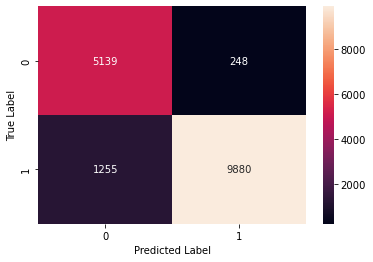

False Positive Rate (FP) -  248
False Negative Rate (FN) -  1255
True Positive Rate (TP) -  9880
True Negative Rate (TN)  -  5139


In [70]:
actua = np.array(test_df['classification'])
predicte = np.array(test_df['predi'])

confusionmatrix = metrics.confusion_matrix(actua, predicte, labels = [0, 1])

sns.heatmap(confusionmatrix, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - ", (confusionmatrix[0][1])) 
print("False Negative Rate (FN) - ", (confusionmatrix[1][0])) 
print("True Positive Rate (TP) - ", (confusionmatrix[1][1])) 
print("True Negative Rate (TN)  - ", (confusionmatrix[0][0])) 

In [75]:
accurac = accuracy_score(actua, predicte)
recal = recall_score(actua, predicte)
precisio = precision_score(actua, predicte)

print(f"Accuracy - {accurac}")
print(f"Recall - {recal}")
print(f"Precision - {precisio}")

Accuracy - 0.9090303837307832
Recall - 0.8872923215087561
Precision - 0.9755134281200631


In [61]:
# When stop words were NOT removed, the following results were obtained: 
# Precision - 0.9755134281200631 
# Recall - 0.8872923215087561 
# Accuracy - 0.9090303837307832

# When stop words were Removed, the following results were obtained:
# Precision - 0.9774292272379494 
# Recall - 0.9178266726537944 
# Accuracy - 0.9303353104950974

In [59]:
# The results show that after the stop words were eliminated, the model's precision, recall, and accuracy improved. 
# This is because deleting these terms allows the model to focus on the most important aspects. 
# Stop words are commonly referred to as meaningless words because they are unimportant and do not convey much information. 
# We can concentrate on the crucial words if we remove the unnecessary ones.

In [60]:
#  A barplot depicting the difference in precision, recall, and accuracy for deleting and 
# not eliminating stop words is shown below:

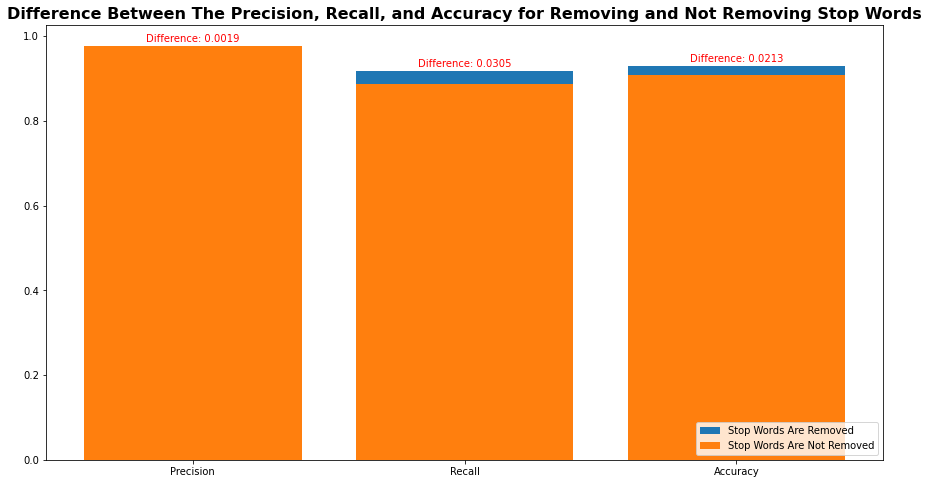

In [56]:
# Values for recall, accuracy, and precision when stop words are left in
precision_notremoved_stopwords = precisio
recall_notremoved_stopwords = recal
accuracy_notremoved_stopwords = accurac

# Values for the precision, recall, and accuracy for removing stop words
precision_removed_stopwords = 0.9774292272379494
recall_removed_stopwords = 0.9178266726537944
accuracy_removed_stopwords = 0.9303353104950974

plt.figure(figsize = (15, 8))
plt.bar(['Precision', 'Recall', 'Accuracy'], [precision_removed_stopwords, recall_removed_stopwords, accuracy_removed_stopwords], label='Stop Words Are Removed')
plt.bar(['Precision', 'Recall', 'Accuracy'], [precision_notremoved_stopwords, recall_notremoved_stopwords, accuracy_notremoved_stopwords], label='Stop Words Are Not Removed')
plt.text(x = 0, y = precision_removed_stopwords + 0.01, s = f"Difference: {precision_removed_stopwords - precision_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.text(x = 1, y = recall_removed_stopwords + 0.01, s = f"Difference: {recall_removed_stopwords - recall_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.text(x = 2, y = accuracy_removed_stopwords + 0.01, s = f"Difference: {accuracy_removed_stopwords - accuracy_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.legend(loc = 'lower right')
plt.title('Difference Between The Precision, Recall, and Accuracy for Removing and Not Removing Stop Words', fontweight = 'bold', fontsize = 16)
plt.show()

In [74]:
# Results when stop words were removed:
# Precision - 0.9774292272379494 
# Recall - 0.9178266726537944 
# Accuracy - 0.9303353104950974